In [15]:
import ee
import geemap.core as geemap
import pandas as pd

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-naranjocdaniela')

In [42]:
# ------------------------
# 1. Definir regiones
# ------------------------

regiones = {
    "Sierra Nevada": ee.Geometry.Polygon([
        [
            [-74.6, 10.2],
            [-73.5, 10.2],
            [-73.5, 11.5],
            [-74.6, 11.5],
            [-74.6, 10.2]
        ]
    ]),
    "Caldas": ee.Geometry.Polygon([
        [
            [-76.2, 4.7],
            [-74.9, 4.7],
            [-74.9, 5.7],
            [-76.2, 5.7],
            [-76.2, 4.7]
        ]
    ])
}

In [43]:
# Colección MODIS NDVI
dataset = ee.ImageCollection('MODIS/061/MOD13Q1').select('NDVI')
#dataset = dataset.filterDate('2015-01-01', '2025-10-31')

In [47]:
# =========================
# 3. Función para obtener NDVI mensual REAL
# =========================

def ndvi_mensual(region_name, geometry, start="2015-01-01", end="2025-10-31"):
    fechas = ee.DateRange(start, end)
    start_date = ee.Date(start)
    end_date = ee.Date(end)

    meses = ee.List.sequence(
        start_date.difference(end_date, 'month').abs().toInt(),
        0, -1
    ).map(lambda i: start_date.advance(i, 'month'))

    registros = []

    for i in range(meses.size().getInfo()):
        inicio_mes = ee.Date(meses.get(i))
        fin_mes = inicio_mes.advance(1, 'month')

        # COMPOSICIÓN MENSUAL CORRECTA
        img_mensual = dataset.filterDate(inicio_mes, fin_mes).mean()

        # Reducir NDVI para toda la región
        val = img_mensual.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=250,
            maxPixels=1e13
        ).get('NDVI').getInfo()

        if val is not None:
            val = val * 0.0001

        mes_str = inicio_mes.format("YYYY-MM").getInfo()
        registros.append([region_name, mes_str, val])

    return pd.DataFrame(registros, columns=['Region', 'Mes', 'NDVI_mensual'])

In [48]:
# =========================
# 4. Obtener datos de ambas regiones
# =========================

dfs = []

for nombre, geom in regiones.items():
    df_region = ndvi_mensual(nombre, geom)
    dfs.append(df_region)

df_final = pd.concat(dfs).reset_index(drop=True)

df_final

,Region,Mes,NDVI_mensual
0,Sierra Nevada,2025-10,0.741886
1,Sierra Nevada,2025-09,0.773110
2,Sierra Nevada,2025-08,0.787096
3,Sierra Nevada,2025-07,0.762631
4,Sierra Nevada,2025-06,0.742989
...,...,...,...
255,Caldas,2015-05,0.604229
256,Caldas,2015-04,0.673003
257,Caldas,2015-03,0.551058
258,Caldas,2015-02,0.602596


In [50]:
# Guardar DataFrame como CSV
df_final.to_csv('ndvi_regiones.csv', index=False)

In [51]:
df_final["NDVI_en_rango"] = df_final["NDVI_mensual"].between(-1, 1)

print("✔ Cantidad de valores fuera del rango esperado (-1 a 1):")
print((~df_final["NDVI_en_rango"]).sum())

# Opcional: ver cuáles están fuera del rango
df_fuera_rango = df_final[~df_final["NDVI_en_rango"]]

✔ Cantidad de valores fuera del rango esperado (-1 a 1):
0


In [52]:
print("✔ Valores faltantes por columna:")
print(df_final.isna().sum())

✔ Valores faltantes por columna:
Region           0
Mes              0
NDVI_mensual     0
NDVI_en_rango    0
dtype: int64


In [59]:
# =======================================
# IQR por región para detectar outliers
# =======================================

# Calcular Q1, Q3 e IQR por región
iqr_df = df_final.groupby("Region")["NDVI_mensual"].agg(
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75)
)
iqr_df["IQR"] = iqr_df["Q3"] - iqr_df["Q1"]
iqr_df["lower"] = iqr_df["Q1"] - 1.5 * iqr_df["IQR"]
iqr_df["upper"] = iqr_df["Q3"] + 1.5 * iqr_df["IQR"]

# Unir de vuelta al dataframe original
df_final = df_final.merge(iqr_df, on="Region", how="left")

# Detectar outliers por región
df_final["Outlier"] = (
    (df_final["NDVI_mensual"] < df_final["lower"]) |
    (df_final["NDVI_mensual"] > df_final["upper"])
)

print("✔ Cantidad de outliers detectados por región:")
print(df_final.groupby("Region")["Outlier"].sum())

# Opcional: ver solo los outliers
df_outliers = df_final[df_final["Outlier"]]
df_outliers

✔ Cantidad de outliers detectados por región:
Region
Caldas           2
Sierra Nevada    1
Name: Outlier, dtype: int64


,Region,Mes,NDVI_mensual,NDVI_en_rango,Outlier,Q1,Q3,IQR,lower,upper
114,Sierra Nevada,2016-04-01,0.552740,True,True,0.665509,0.740176,0.074667,0.553509,0.852176
138,Caldas,2025-02-01,0.411145,True,True,0.573318,0.680264,0.106947,0.412898,0.840684
166,Caldas,2022-10-01,0.412798,True,True,0.573318,0.680264,0.106947,0.412898,0.840684


In [54]:
df_outliers

,Region,Mes,NDVI_mensual,NDVI_en_rango,Outlier
138,Caldas,2025-02,0.411145,True,True
166,Caldas,2022-10,0.412798,True,True


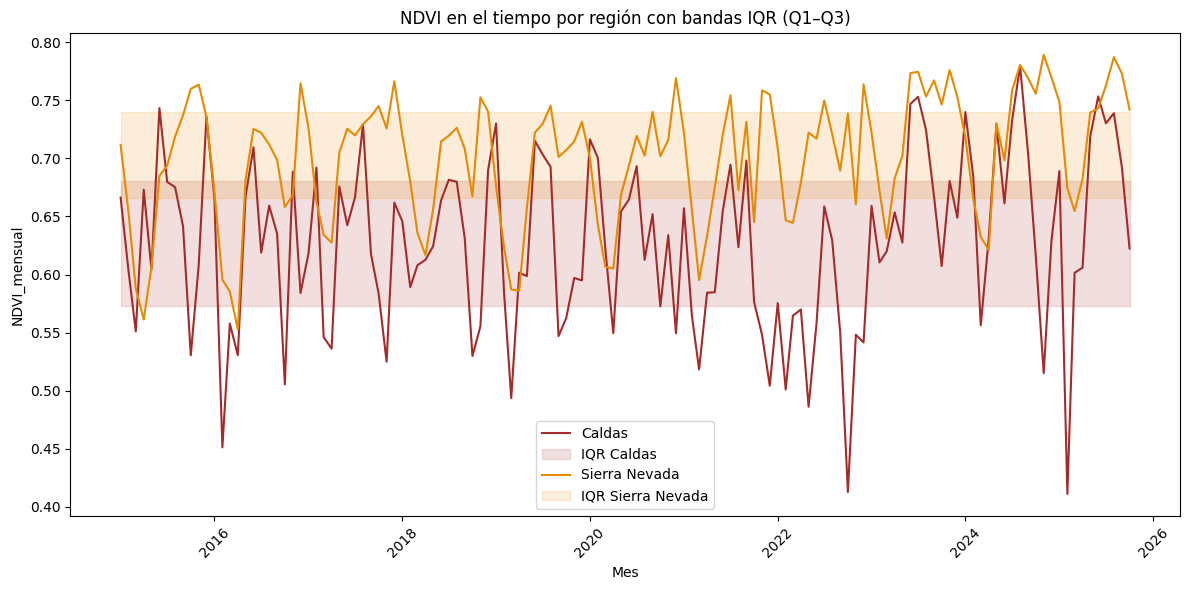

In [60]:
import matplotlib.pyplot as plt

# Convertir la columna Mes a datetime
df_final["Mes"] = pd.to_datetime(df_final["Mes"], format="%Y-%m")

# Ordenar por fecha
df_final_sorted = df_final.sort_values("Mes")

plt.figure(figsize=(12,6))

# =========================
#   Región: Caldas
# =========================
subset_caldas = df_final_sorted[df_final_sorted["Region"] == "Caldas"]

# Línea
plt.plot(
    subset_caldas["Mes"],
    subset_caldas["NDVI_mensual"],
    label="Caldas",
    color="#A52A2A"
)

# Banda Q1–Q3
plt.fill_between(
    subset_caldas["Mes"],
    subset_caldas["Q1"],
    subset_caldas["Q3"],
    color="#A52A2A",
    alpha=0.15,               # transparencia
    label="IQR Caldas"
)

# =========================
#   Región: Sierra Nevada
# =========================
subset_sierra = df_final_sorted[df_final_sorted["Region"] == "Sierra Nevada"]

# Línea
plt.plot(
    subset_sierra["Mes"],
    subset_sierra["NDVI_mensual"],
    label="Sierra Nevada",
    color="#E68A00"
)

# Banda Q1–Q3
plt.fill_between(
    subset_sierra["Mes"],
    subset_sierra["Q1"],
    subset_sierra["Q3"],
    color="#E68A00",
    alpha=0.15,
    label="IQR Sierra Nevada"
)

# =========================
# Configuración del gráfico
# =========================
plt.xlabel("Mes")
plt.ylabel("NDVI_mensual")
plt.title("NDVI en el tiempo por región con bandas IQR (Q1–Q3)")
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()